# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [ ]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-08-12 07:36:11--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  50.5MB/s    in 3.8s    

2021-08-12 07:36:15 (45.2 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-08-12 07:36:15--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  57.2MB/s    in 1.1s    

2021-08-12 07:36:16 (57.2 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-08-12 07:36:16--
Total wall clock time: 5.1s
Downloaded: 2 files, 235M i

In [ ]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [ ]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [ ]:
# First, lets load the dataset
data_train = dset.SVHN('./',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [ ]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, n_schedule=1):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        if scheduler is not None:
          if epoch % n_schedule==0:
                scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    
    model.eval() 
    
    loss_accum = 0
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        
        prediction = model(x_gpu)    
        loss_value = loss(prediction, y_gpu)
                    
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
            
        loss_accum += loss_value

    ave_loss = loss_accum / (i_step + 1)
    accuracy = float(correct_samples) / total_samples 
    
    return accuracy

In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Average loss: 1.414996, Train accuracy: 0.526277, Val accuracy: 0.745956
Average loss: 0.701514, Train accuracy: 0.787735, Val accuracy: 0.780015
Average loss: 0.595002, Train accuracy: 0.821537, Val accuracy: 0.808341
Average loss: 0.552774, Train accuracy: 0.833891, Val accuracy: 0.824654
Average loss: 0.518202, Train accuracy: 0.843873, Val accuracy: 0.837281


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [ ]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


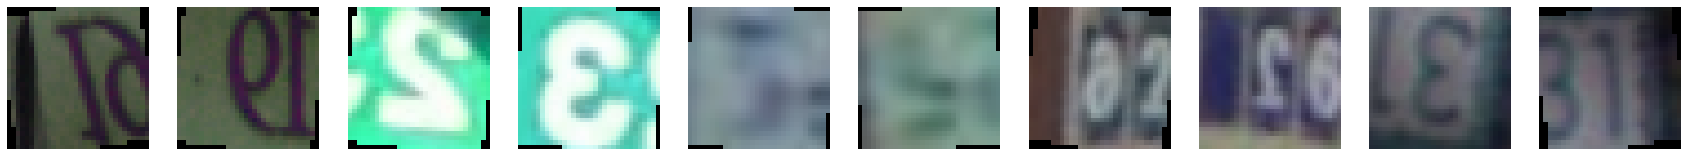

In [ ]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [ ]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose


data_aug_train = dset.SVHN('./', transform=tfs)

data_size = data_aug_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [ ]:
# Finally, let's train with augmentations!
# Note we shouldn't use augmentations on validation
loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.608579, Train accuracy: 0.815104, Val accuracy: 0.820012
Average loss: 0.561620, Train accuracy: 0.830034, Val accuracy: 0.850727
Average loss: 0.541774, Train accuracy: 0.836092, Val accuracy: 0.851546
Average loss: 0.526772, Train accuracy: 0.839607, Val accuracy: 0.850932
Average loss: 0.511432, Train accuracy: 0.843753, Val accuracy: 0.861375


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [ ]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Tanh(),            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Tanh(), 
            Flattener(),
            nn.Tanh(),
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.989634, Train accuracy: 0.298212, Val accuracy: 0.633609
Average loss: 0.830760, Train accuracy: 0.741426, Val accuracy: 0.800901
Average loss: 0.600980, Train accuracy: 0.816708, Val accuracy: 0.852297
Average loss: 0.528714, Train accuracy: 0.837679, Val accuracy: 0.861852
Average loss: 0.481316, Train accuracy: 0.851039, Val accuracy: 0.877073


KeyboardInterrupt: ignored

# Подбор гиперпараметров

In [18]:
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])


learning_rates = [1e0, 1e-1]
anneal_coeff = 0.2
anneal_epochs = [5]
reg = [1e-4, 1e-5]

epoch_num = 10

run_record = {} 

for lr in learning_rates:
  for rg in reg:
    for ae in anneal_epochs:
      lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Tanh(),            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Tanh(), 
            Flattener(),
            nn.Tanh(),
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
          )
      lenet_model.type(torch.cuda.FloatTensor)
      lenet_model.to(device)
      
      loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
      optimizer = optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=rg)
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=anneal_coeff)

      loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num,
                                                             scheduler=scheduler, n_schedule=ae)

      run_record[Hyperparams(lr, ae, rg)] = RunResult(lenet_model, train_history, val_history, val_history[-1])

Average loss: 1.481292, Train accuracy: 0.504334, Val accuracy: 0.758174
Average loss: 0.609710, Train accuracy: 0.809934, Val accuracy: 0.844243
Average loss: 0.538695, Train accuracy: 0.834334, Val accuracy: 0.858644
Average loss: 0.498251, Train accuracy: 0.845715, Val accuracy: 0.873251
Average loss: 0.467661, Train accuracy: 0.855510, Val accuracy: 0.879053
Average loss: 0.441273, Train accuracy: 0.861891, Val accuracy: 0.879394
Average loss: 0.377752, Train accuracy: 0.884022, Val accuracy: 0.900212
Average loss: 0.363546, Train accuracy: 0.887554, Val accuracy: 0.902054
Average loss: 0.357844, Train accuracy: 0.888663, Val accuracy: 0.902942
Average loss: 0.350896, Train accuracy: 0.892212, Val accuracy: 0.903624
Average loss: 1.381407, Train accuracy: 0.542931, Val accuracy: 0.766228
Average loss: 0.566244, Train accuracy: 0.828294, Val accuracy: 0.858576
Average loss: 0.494215, Train accuracy: 0.850834, Val accuracy: 0.873729
Average loss: 0.459758, Train accuracy: 0.858769, V

In [19]:
best_val_accuracy = None
best_hyperparams = None
best_run = None
best_model = None 

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        best_model = run_result.model
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.91, best hyperparams: Hyperparams(learning_rate=1.0, anneal_epochs=5, reg=1e-05)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [63]:
best_model = None

learning_rate = 1e-1
anneal_coeff = 0.8
anneal_epochs = 1
reg = 1e-4

epoch_num = 20

model = nn.Sequential(
  nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
  nn.BatchNorm2d(6),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
  nn.BatchNorm2d(16),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  Flattener(),
  nn.ReLU(inplace=True),
  nn.Linear(400, 120),
  nn.BatchNorm1d(120),
  nn.ReLU(inplace=True),
  nn.Linear(120, 84),
  nn.BatchNorm1d(84),
  nn.ReLU(inplace=True),
  nn.Linear(84, 10)
)
model.type(torch.cuda.FloatTensor)
model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=anneal_coeff)

loss_history, train_history, val_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, epoch_num,
                                                    scheduler=scheduler, n_schedule=anneal_epochs)

Average loss: 0.743633, Train accuracy: 0.765638, Val accuracy: 0.863627
Average loss: 0.465875, Train accuracy: 0.855561, Val accuracy: 0.891270
Average loss: 0.404795, Train accuracy: 0.875183, Val accuracy: 0.908539
Average loss: 0.368709, Train accuracy: 0.886377, Val accuracy: 0.916388
Average loss: 0.344125, Train accuracy: 0.895489, Val accuracy: 0.923077
Average loss: 0.321438, Train accuracy: 0.902484, Val accuracy: 0.925807
Average loss: 0.310359, Train accuracy: 0.905846, Val accuracy: 0.932087
Average loss: 0.295511, Train accuracy: 0.910026, Val accuracy: 0.934066
Average loss: 0.285740, Train accuracy: 0.914633, Val accuracy: 0.937410
Average loss: 0.276377, Train accuracy: 0.917278, Val accuracy: 0.937001
Average loss: 0.266346, Train accuracy: 0.920076, Val accuracy: 0.941437
Average loss: 0.263660, Train accuracy: 0.921305, Val accuracy: 0.941847
Average loss: 0.258095, Train accuracy: 0.923353, Val accuracy: 0.942188
Average loss: 0.253345, Train accuracy: 0.923830, V

In [64]:
best_model = model

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [65]:
# TODO Write the code to compute accuracy on test set
test_indices = list(range(data_test.data.shape[0]))

test_sampler = SubsetRandomSampler(test_indices)

test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size,
                                         sampler=test_sampler)

final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9028887523048555


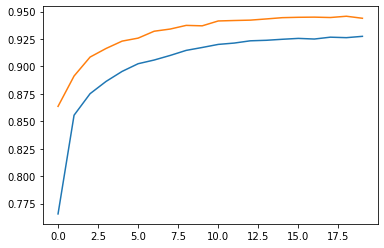

In [66]:
plt.plot(train_history)
plt.plot(val_history)